## Create unpopular image set

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

data = pd.read_json("../../temp_data/replay_buffer_train.json", orient="records", lines=True)

In [9]:
data.head()

,state,action,r_act,next_state,true_state_len,true_next_state_len,is_end
0,"[105969, 96730, 44893, 105969, 44893, 105969, ...",5637,1,"[105969, 96730, 44893, 105969, 44893, 105969, ...",7,8,True
1,"[45149, 45149, 52629, 77126, 77126, 125513, 77...",3995,1,"[45149, 52629, 77126, 77126, 125513, 77126, 52...",10,10,False
2,"[52629, 77126, 77126, 125513, 77126, 5279, 356...",6900,1,"[77126, 77126, 125513, 77126, 5279, 35613, 951...",10,10,False
3,"[125513, 77126, 5279, 35613, 95193, 86025, 786...",9882,1,"[77126, 5279, 35613, 95193, 86025, 78609, 1064...",10,10,False
4,"[77126, 5279, 35613, 95193, 86025, 78609, 1064...",558,1,"[5279, 35613, 95193, 86025, 78609, 106429, 103...",10,10,False


Number of unique images: 6304


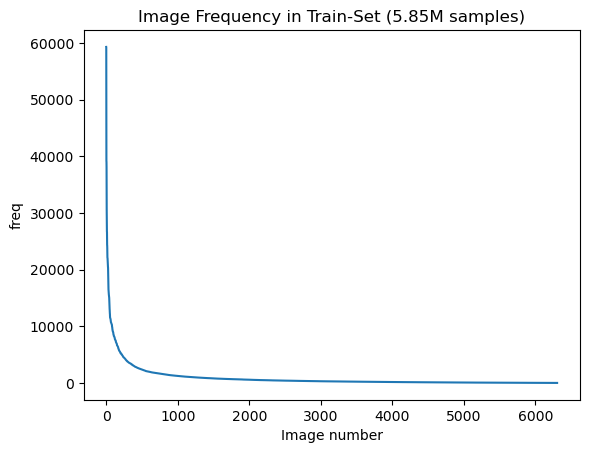

In [4]:
import matplotlib.pyplot as plt
num_imgs = len(data.action.unique())
print(f"Number of unique images: {num_imgs}")

plt.plot(range(0,num_imgs),data.action.value_counts())
plt.title(f"Image Frequency in Train-Set ({len(data)/1e6:.2f}M samples)")
plt.xlabel("Image number")
plt.ylabel("freq")
plt.show()

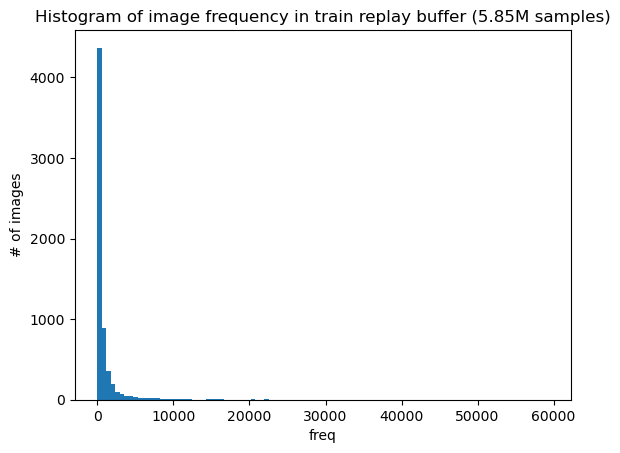

In [66]:
num_imgs = len(data.action.unique())
plt.hist(data.action.value_counts(), bins=100)
plt.title(f"Histogram of image frequency in train replay buffer ({len(data)/1e6:.2f}M samples)")
plt.xlabel("freq")
plt.ylabel("# of images")
plt.show()

In [67]:
data.action.value_counts().quantile(q=[0.1,0.25, 0.5, 0.75,0.9])

0.10      32.0
0.25      92.0
0.50     272.5
0.75     756.0
0.90    1879.0
Name: action, dtype: float64

In [73]:
import numpy as np
# Get sorted item frequency
sorted_freq = data["action"].value_counts().sort_values(ascending=False)
freq_thresh = np.quantile(sorted_freq, q=0.9)

# Get itemIDs with frequency smaller than thresh
unpopular_items = sorted_freq[sorted_freq < freq_thresh].index.values

print(f"Number popular items excluded: {num_imgs-len(unpopular_items)} from {num_imgs}")


Number popular items excluded: 632 from 6304


In [86]:
# Let's check a few
counted = data.action.value_counts()
print(f"{counted.index[0] in unpopular_items}")
print(f"{counted.index[100] in unpopular_items}")
print(f"{counted.index[300] in unpopular_items}")
print(f"{counted.index[631] in unpopular_items}")
print(f"{counted.index[632] in unpopular_items}")

# Yes, makes sense.

False
False
False
False
True


In [76]:
from recommenders.utils.tokenizer import Tokenizer

output_tokenizer = Tokenizer.from_file("../../data/IKEA/tokenizers/output_tokenizer.json")

In [77]:
# Now add images that are not included in the full train from big json
import json
with open("../../data/IKEA/insp_feed_dict.json", "r") as file:
    if_dict = json.load(file)

In [78]:
all_json_images = set(map(lambda x: output_tokenizer.stoi(x), list(if_dict.keys())))
all_train_images = set(data.action.unique())

to_add = all_json_images - all_train_images

print(8195 in all_train_images)
print(8195 in all_json_images)
print(8195 in to_add)
print(8195 in unpopular_items)
print("Len before: ", len(unpopular_items))

unpopular_items = set(unpopular_items).union(to_add)

print(8195 in unpopular_items)
print("Len after: ", len(unpopular_items))

False
True
True
False
Len before:  5672
True
Len after:  9472


In [79]:
# Safe unpopular images
import os
import json
to_dump = list(unpopular_items)
to_dump = [int(x) for x in unpopular_items]
with open(os.path.join("../../data/IKEA", "unpopular_images.json"), "w") as f:
        json.dump(to_dump, f)

In [81]:
with open('../../data/IKEA/unpopular_images.json', 'r') as f:
    mylist = json.load(f)

print(len(mylist))
print(10107-632)

9472
9475


In [90]:
counted.index[110] in mylist

False

# Visualize

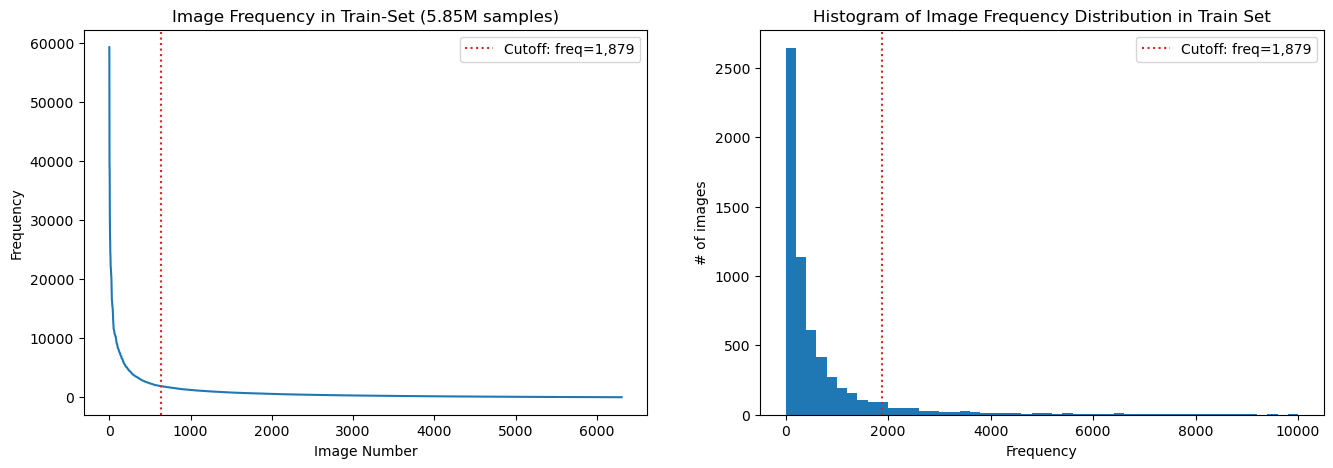

In [24]:
import numpy as np

sorted_freq = data["action"].value_counts()
freq_thresh = np.quantile(sorted_freq, q=0.90)
item_idx =  np.argmax(sorted_freq<freq_thresh)

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(range(0,num_imgs),sorted_freq)
plt.axvline(x=item_idx, color='C3', linestyle=':', label=f"Cutoff: freq={int(freq_thresh):,}")
plt.title(f"Image Frequency in Train-Set ({len(data)/1e6:.2f}M samples)")
plt.xlabel("Image Number")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1,2,2)
plt.hist(sorted_freq, bins=50, range=(0,10000) )
plt.axvline(x=freq_thresh, color='C3', linestyle=':', label=f"Cutoff: freq={int(freq_thresh):,}")
plt.title(f"Histogram of Image Frequency Distribution in Train Set")
plt.xlabel("Frequency")
plt.ylabel("# of images")
plt.legend()
plt.savefig(fname="report_img/image_freq", dpi=300, bbox_inches='tight')
plt.show()